In [41]:
import json
import re

In [42]:
def read_output_file(path, reverse=False):
    # path = "../experiments/somos/ab_testing/diff15_prompt1.txt"
    outputs = []
    with open(path, "r") as f:
        for line in f:
            x = json.loads(line)
            outputs.append(x)
    
    count_all, count_correct, count_incorrect, error = 0, 0, 0, 0
    predictions = []
    for output in outputs:
        if not reverse:
            audio_a, audio_b = output['data']
        else:
            audio_b, audio_a = output['data']
        
        verdict_text = output['processed']
        assert verdict_text in ['A', 'B', 'C']
        
        if verdict_text == "A":
            if audio_a['mos'] > audio_b['mos']:
                count_correct += 1
                evaluation = "correct"
            else:
                count_incorrect += 1
                evaluation = "incorrect"
        elif verdict_text == "B":
            if audio_a['mos'] < audio_b['mos']:
                count_correct += 1
                evaluation = "correct"
            else:
                count_incorrect += 1
                evaluation = "incorrect"
        else:
            evaluation = 'error'
            error += 1
        count_all += 1
        predictions.append([evaluation, verdict_text, audio_a['mos'], audio_b['mos']])
    print("total:", count_all)
    print("correct:   {:.2f}%".format(count_correct/count_all*100))
    print("incorrect: {:.2f}%".format(count_incorrect/count_all*100))
    print("error:     {:.2f}%".format(error/count_all*100))
    return predictions

In [43]:
predictions_f2 = read_output_file("../experiments/somos/ab_testing/diffall_qwen2_prompt2.processed.txt")

total: 3604
correct:   12.68%
incorrect: 14.46%
error:     72.86%


In [47]:
predictions_ab = read_output_file("../experiments/somos/ab_testing/diffall_qwen2_prompt2_format1.processed.txt", reverse=False)

total: 3567
correct:   25.51%
incorrect: 24.31%
error:     50.18%


In [48]:
predictions_ba = read_output_file("../experiments/somos/ab_testing/diffall_qwen2_prompt2_format1_BA.processed.txt", reverse=True)

total: 3567
correct:   23.30%
incorrect: 21.90%
error:     54.81%


In [49]:
abba_correct, abba_incorrect, abba_error = 0, 0, 0
for x in predictions_ab + predictions_ba:
    if x[0] == 'correct':
        abba_correct += 1
    elif x[0] == 'incorrect':
        abba_incorrect += 1
    elif x[0] == 'error':
        abba_error += 1
    else:
        raise Exception()
print("total:", abba_correct+abba_incorrect+abba_error)
print("correct: {:.2f}%".format(abba_correct/(abba_correct+abba_incorrect+abba_error)*100))
print("incorrect: {:.2f}%".format(abba_incorrect/(abba_correct+abba_incorrect+abba_error)*100))

total: 7134
correct: 24.40%
incorrect: 23.10%


## System-level Analysis

In [50]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

In [51]:
def analyze_correlation_and_plot(list_a, list_b):
    # 1. Compute Pearson correlation
    pearson_corr, _ = stats.pearsonr(list_a, list_b)

    # 2. Compute Spearman correlation
    spearman_corr, _ = stats.spearmanr(list_a, list_b)

    # Print results
    print(f"Pearson Correlation: {pearson_corr:.3f}")
    print(f"Spearman Correlation: {spearman_corr:.3f}")

    # 4. Scatter plot with best-fit line
    plt.figure(figsize=(5, 4))
    plt.scatter(list_a, list_b, color='blue', label='Data points')

    # Best fit line
    coefficients = np.polyfit(list_a, list_b, 1)  # Linear fit (degree=1)
    poly = np.poly1d(coefficients)
    best_fit_line = poly(list_a)

    plt.plot(list_a, best_fit_line, color='red', label='Best Fit Line')
    plt.xlabel('MOS (GT)')
    plt.ylabel('AudioJudge Prediction (Win Rate)')
    plt.title('Scatter Plot with Best Fit Line')
    plt.legend()
    plt.grid()
    plt.show()

Pearson Correlation: 0.010
Spearman Correlation: 0.040


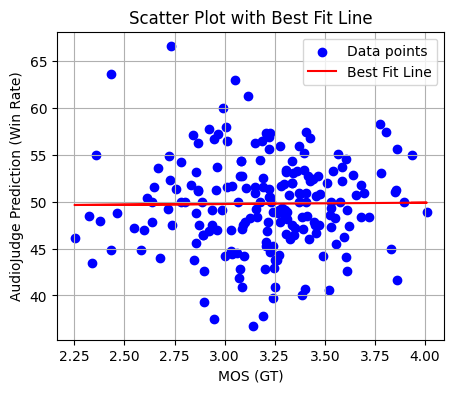

In [52]:
# def evaluate_system_level():
pred_by_system, gts_by_system = {}, {}

reverse = False
path = "../experiments/somos/ab_testing/diffall_qwen2_prompt2_format1.processed.txt"
outputs = []
with open(path, "r") as f:
    for line in f:
        x = json.loads(line)
        outputs.append(x)
for output in outputs:
    audio_a, audio_b = output['data']
    model_a = audio_a['uttId'].split('_')[-1]
    model_b = audio_b['uttId'].split('_')[-1]
    if model_a not in pred_by_system: pred_by_system[model_a] = []
    if model_a not in gts_by_system:  gts_by_system[model_a] = []
    if model_b not in pred_by_system: pred_by_system[model_b] = []
    if model_b not in gts_by_system:  gts_by_system[model_b] = []

    verdict_text = output['processed']
    assert verdict_text in ['A', 'B', 'C']
        
    if verdict_text == "A":
        pred_by_system[model_a] += [1]
        pred_by_system[model_b] += [0]
    elif verdict_text == "B":
        pred_by_system[model_a] += [0]
        pred_by_system[model_b] += [1]
    elif verdict_text == "C":
        pred_by_system[model_a] += [0.5]
        pred_by_system[model_b] += [0.5]    
    else:
        raise Exception()

    gts_by_system[model_a] += [audio_a['mos']]
    gts_by_system[model_b] += [audio_b['mos']]

reverse = True
path = "../experiments/somos/ab_testing/diffall_qwen2_prompt2_format1_BA.processed.txt"
outputs = []
with open(path, "r") as f:
    for line in f:
        x = json.loads(line)
        outputs.append(x)
for output in outputs:
    audio_b, audio_a = output['data']
    model_a = audio_a['uttId'].split('_')[-1]
    model_b = audio_b['uttId'].split('_')[-1]
    if model_a not in pred_by_system: pred_by_system[model_a] = []
    if model_a not in gts_by_system:  gts_by_system[model_a] = []
    if model_b not in pred_by_system: pred_by_system[model_b] = []
    if model_b not in gts_by_system:  gts_by_system[model_b] = []

    verdict_text = output['processed']
    assert verdict_text in ['A', 'B', 'C']
        
    if verdict_text == "A":
        pred_by_system[model_a] += [1]
        pred_by_system[model_b] += [0]
    elif verdict_text == "B":
        pred_by_system[model_a] += [0]
        pred_by_system[model_b] += [1]
    elif verdict_text == "C":
        pred_by_system[model_a] += [0.5]
        pred_by_system[model_b] += [0.5]    
    else:
        raise Exception()

    gts_by_system[model_a] += [audio_a['mos']]
    gts_by_system[model_b] += [audio_b['mos']]

system_level_pred, system_level_gts = [], []
systems = []
for system, pred in pred_by_system.items():
    gts = gts_by_system[system]
    assert len(pred) == len(gts)
    system_level_pred.append(np.mean(pred)*100)
    system_level_gts.append(np.mean(gts))
    systems.append(system)
analyze_correlation_and_plot(system_level_gts, system_level_pred)